In [1]:
import fastai
from fastai.vision.all import *

In [2]:
fastai.__version__

'2.0.18'

In [2]:
train = pd.read_csv("/kaggle/input/tuberculosis-xray/Train.csv")

test = pd.read_csv("/kaggle/input/tuberculosis-xray/Test.csv")

train["LABEL"] = [str(i) for i in train["LABEL"]]

train["new_filenames"] = [(str(i) + ".png") for i in train["ID"]]

test["new_filenames"] = [(str(i) + ".png") for i in test["ID"]]

test["LABEL"] = [str(0) for i in test["ID"]]


In [3]:
dls = ImageDataLoaders.from_df(train, path="/kaggle/input/tuberculosis-xray/combined_images/combined_images - Copy",
#                                folder='train_small', 
                               fn_col='new_filenames', 
                               label_col = 'LABEL',
#                                label_delim=' ',
                               item_tfms=Resize(460), 
                               seed = 42,
                               batch_tfms=aug_transforms(size=224),
                               valid_pct = 0.2)

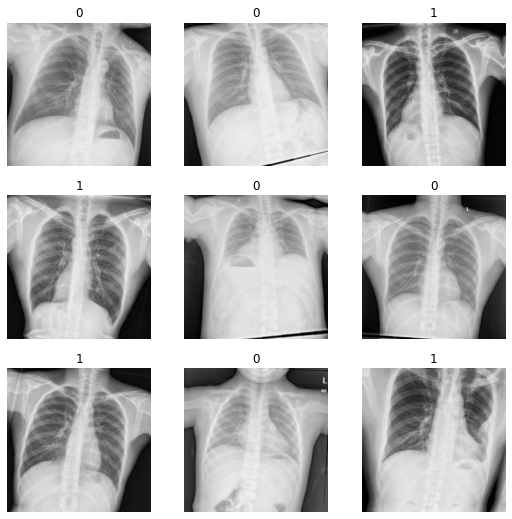

In [4]:
dls.show_batch()

In [18]:
learn = cnn_learner(dls, resnet152, 
                    metrics=accuracy, 
                    model_dir='/kaggle/working/models')

# resnet34, resnet50, resnet101, resnet152
# densenet121, densenet169, densenet201, densenet161

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


SuggestedLRs(lr_min=0.006918309628963471, lr_steep=3.311311274956097e-06)

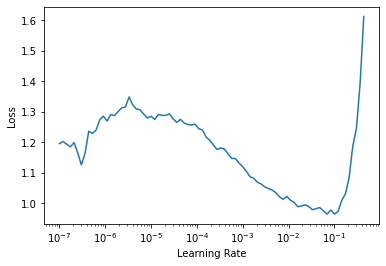

In [13]:
learn.lr_find()

In [19]:
# slice(1e-6, 1e-4)
learn.fine_tune(15, 0.00691830)

epoch,train_loss,valid_loss,accuracy,time
0,1.169456,3.372139,0.566434,00:13


epoch,train_loss,valid_loss,accuracy,time
0,1.136297,2.548936,0.559441,00:13
1,1.020015,0.836476,0.755245,00:13
2,0.848915,2.467905,0.678322,00:13
3,0.739491,2.073664,0.664336,00:14
4,0.644773,1.070846,0.790210,00:13
5,0.564364,0.698286,0.783217,00:14
6,0.504299,0.325680,0.881119,00:13
7,0.439648,0.626098,0.867133,00:13
8,0.392514,0.522551,0.881119,00:13
9,0.343110,0.623353,0.881119,00:13


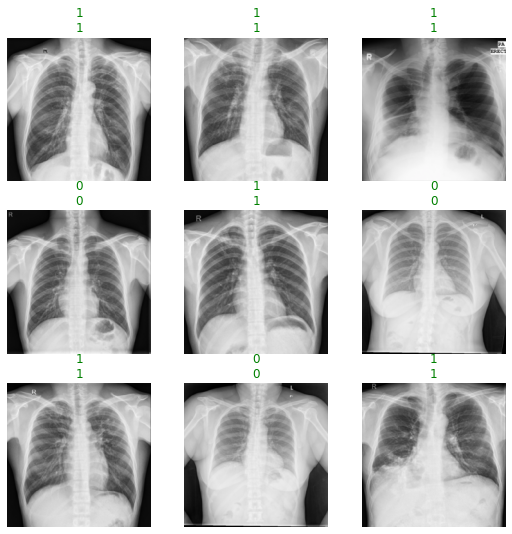

In [15]:
learn.show_results()

In [18]:
dls_test = ImageDataLoaders.from_df(test, path="/kaggle/input/tuberculosis-xray/test_small/test_small",
                               folder='test_small', 
                               fn_col='new_filenames', 
#                                 label_col = 'LABEL',
#                                label_delim=' ',
                               item_tfms=Resize(460), 
                               batch_tfms=aug_transforms(size=224),
                               valid_pct = 0.2)

In [20]:
test_dl=learn.dls.test_dl(test)
preds, _ = learn.tta(dl=test_dl)

In [24]:
preds.numpy()[:10]

array([[0.95129776, 0.04870221],
       [0.8853368 , 0.11466318],
       [0.6991298 , 0.30087015],
       [0.55254525, 0.4474548 ],
       [0.80180633, 0.19819367],
       [0.21193193, 0.78806806],
       [0.8489044 , 0.15109563],
       [0.52367437, 0.4763256 ],
       [0.7431466 , 0.2568534 ],
       [0.09677651, 0.90322345]], dtype=float32)

In [21]:
ss = pd.read_csv('/kaggle/input/tuberculosis-xray/SampleSubmission.csv')
ss['LABEL'] = preds.numpy()[:, 1]
filename = "fastai_resnet152_15epochs.csv"
ss.to_csv("/kaggle/working/"+filename, index = False)